In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("stats_ttest.ipynb")

# What is in this assignment

-More practice with Python's numpy and scipy libraries
 -- Kmeans, stats library, random number generation, ransac/robust statistics, simple data fitting
 -- Gaussian assumptions
- Data analysis

Slides: https://docs.google.com/presentation/d/1G7nRl2zlwGrdodZyJXtsAfDU5yB7oSGVxSim8x_hzbw/edit?usp=sharing

# Scenario: You have a data set that you *think* clusters into two groups. 
For each data point you have an associated y value; once you've split the data set into clusters you also want to find the y=f(x) value for each cluster

- Version 1: You're given the labels (supervised learning) and you want to see if they're distinguishable
- Version 2: You are NOT given the labels, so you use k-means to get an initial labeling, and (optionally) a very simplified version of RANSAC to improve the label assignment

## Assumptions:
- The x values for each cluster are normally distributed around the cluster's center - i.e., the noise is normally distributed
- The y values are related to the x values by a Gaussian, i.e., f is a Gaussian. Note that it could be anything else - a polynomial, etc
- There are random outliers in the data set - these points are random both in x and y

## Analysis steps (some of these are done for you):
1) Plot the data to determine if you can at least *visually* separate the clusters. We'll do two plots - one that shows the x,y values, the second that shows the distribution of the x-values
 - if the distribution of the x-values does not have two reasonably clear peaks, you can't separate the two sets of samples

2) Version 1: Run a t-test on the known labels to determine if the two x-value distributions are distinguishable
2) Version 2: Find the x centers of the clusters using kmeans on the x values
3) CHECK that these are two distinct clusters using a t-test
4) "Fit" a Gaussian to each data set to get an approximation of the parameters for the f function (mu and sigma)
5) [Optional] Remove outliers (data points that are not on the Guassian) using a RANSAC algorithm
6) CHECK that there's a reasonable Gaussian fit to the two data sets
7) [Optional] do a curve fit to further improve the Gaussian reconstruction
8) Plot your results over the original data

##   To play with: The parameters that you're given at the start should pass both checks. 
For the last part of the assignment, deliberately "break" the t-test/reconstruction in the following ways
1) Move the centers together so that the two x distributions are not distinguishable (the histogram does not have two peaks). Does the t-test fail? What does k-means do? How "good" are the Gaussian fits? Is each data set a Gaussian? How close can you get before the remove_outlier code is no longer able to 'fix' the result?
2) Change just the standard deviations, the number of samples, and the noise level until the t-test breaks. What happens to the kmeans result? Can the remove_outlier code 'fix' the result? How does the added noise play into this?
3) Change the ratio of the number of samples for each peak. As the ratio moves farther and farther away from 50/50, what happens to the original t-test? What happens to the kmeans split?
4) Re-labeling and re-assignment (optional) - What happens if you re-label? What problems can it fix? Try relabeling once versus twice. Try making the gaussians more similar (moving their centers together, changing sampling ratios, increasing overlap)
5) Noise and outlier removal (optional) - What happens if you crank up the noise on the y-values? At what point does the re-labeling/outlier removal break down? What happens if you increase/decrease the aggressivenes of the outlier removal?

## Other things to play with:
1) What happens if you set the number of clusters to 3, 4, or 5? (code will crash if more than 5)
2) What happens if you increase the number of random samples? How many can you tolerate?

Note 1: I plot the y values with the x values, but you are doing clustering on the x values ONLY, and then fitting the y values - you're not clustering on both together

Note 2: I've included all of the libraries/methods you should need (imports)

In [2]:
# Doing the imports for you - you should be able to do this entire assignment with these imports
import numpy as np
from numpy.random import uniform, normal
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit

## Data generation

I've written these for you. These two functions generate the samples/data that we'll be using for this assignment.

In [3]:
# Gaussian function
def gaussian(x, mu, sigma):
    """Gaussian with given mean, sigma
    @param x - the input x value
    @param mu - the mean
    @param sigma - the standard deviation
    @return y = gauss(x) """
    return (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

In [4]:
# Generate data from two normal distributions, with some random additional noise
def two_gaussians(mus, sigmas, noise_level, n_samples):
    """ Generate some random data with two peaks
    The closer the means relative to their standard deviations, plus the more noise, and the more uneven the number
    of samples, the harder it will be to tell there are two standard deviations the two distributions apart
    @param mus - centers of the two gaussians
    @param sigmas - standard deviations of the two gaussians
    @param noise_level - how much uniform noise to add to y value
    @param n_samples - Number of samples for the gaussians, and the uniform noise (triplet of integers)
    @return a 2 X sum(n_samples) array, x values in the first row, and the original labels (0, 1, -1)
    """
    # Pre-allocate space - in this case, just easier to do this than to try to do an append/build of some sort
    samples = np.zeros((2, sum(n_samples)))
    orig_labels = np.zeros((sum(n_samples)), dtype=int)

    # The Gaussian samples, with noise added to the y values
    n_start = 0
    for i, (mu, sigma, n) in enumerate(zip(mus, sigmas, n_samples[0:2])):
        # Get x values that are normally distributed
        samples[0, n_start:n_start+n] = normal(mu, sigma, n)
        orig_labels[n_start:n_start+n] = i
        # Evaluate Guassian at those x values and add noise based on height of gaussian
        y_noise = noise_level * gaussian(mu, mu, sigma)
        noise_y = uniform(-y_noise / 2.0, y_noise / 2.0, n)
        samples[1, n_start:n_start+n] = gaussian(samples[0, n_start:n_start+n], mu, sigma) + noise_y
        n_start += n

    # Random noise evenly distributed across the x/y spectrum
    #   Uniformally distribute x samples across the x values from the two Gaussians
    #      and same for y
    for i in range(0, 2):
        samples[i, n_start:n_start + n_samples[2]] = uniform(np.min(samples[i, 0:n_start]),
                                                             np.max(samples[i, 0:n_start]), n_samples[2])
    orig_labels[n_start:n_start + n_samples[2]] = -1
    
    # 2xn array of samples, 1xn array of labels
    return samples, orig_labels


## Plotting
I've written several plotting routines for you; you shouldn't have to change these. You SHOULD look to see what the code does/how it does it

I always like to put plotting code into a function, because, chances are, you'll need to call it more than once at some point. Also, plotting gets really messy, so it's nice to hide the messyness.

In [5]:
def plot_samples(axs, samples, mus, sigmas, n_samples):
    """ Plot the samples and the source Gaussians
    @param axs - the plot window to draw into
    @param samples - the 2xn set of samples, divvied up by n_samples
    @param mus - the means
    @param sigmas - the standard deviations
    @param n_samples - a triplet, number of samples for each Gaussian plus the noise"""
    
    # I like using fancy colors...
    colors = ['lightcoral', 'aqua', 'magenta']

    n_start = 0
    str_title = "Original samples\n"
    for i, n in enumerate(n_samples):
        n_end = n_start + n
        axs.scatter(samples[0, n_start:n_end],
                    samples[1, n_start:n_end], c=colors[i], marker='.')

        # The Gaussians - plot the original curves as well as the samples
        if i < 2:
            x_min = np.min(samples[0, n_start:n_end])
            x_max = np.max(samples[0, n_start:n_end])
            xs = np.linspace(x_min, x_max, 100)
            axs.plot(xs, gaussian(xs, mus[i], sigmas[i]), color=colors[i], linestyle='-')
            str_title = str_title + f"mu {mus[i]:0.1f} sigma {sigmas[i]:0.2f}\n"

        n_start += n
    str_title = str_title[0:-1]   # Take out the extra \n
    axs.set_title(str_title)

In [6]:
def plot_density(axs, samples):
    """ Plot the density of the samples along the x axis
    @param axs - subplot window
    @param samples - the samples"""
    axs.hist(samples[0, :], bins=40)
    axs.set_title("X-density samples")

In [7]:
def plot_kmeans_result(axs, centers, samples, sample_ids):
    """ Plot what kmeans returned to us
    @param axs - window to plot into
    @param centers - the centers returned by kmenas
    @param samples - the original samples,
    @param sample_ids - the cluster each sample was assigned to"""
    colors = ['lightcoral', 'aqua', 'magenta', 'grey', 'blue']
    for i in range(0, len(centers)):
        axs.scatter(samples[0, sample_ids == i], samples[1, sample_ids == i], c=colors[i], marker='.')

    # Plot the centers afterwards so they show up on top
    for i in range(0, len(centers)):
        axs.plot(centers[i], 0, color='black', marker='x', markersize=10)
        axs.plot(centers[i], 0, color=colors[i], marker='x', markersize=8)

In [8]:
def plot_fit_results(axs, in_str_title, fitted_mus, fitted_sigmas, errs, samples, labels):
    """ Plot the samples with labels and the fitted gaussian curves
    @param axs - figure to plot in
    @param in_str_title - title to start plot with
    @param fitted_mus - the fitted means
    @param fitted_sigmas - the fitted sigmas
    @param errs - the L2 errors
    @param samples - the original samples
    @param labels - the original labels - label -1 means outlier"""
    colors = ['lightcoral', 'aqua', 'magenta', 'grey', 'blue']

    str_title = in_str_title + "\n"
    for i, (mu, sigma, err) in enumerate(zip(fitted_mus, fitted_sigmas, errs)):
        axs.scatter(samples[0, labels == i],
                    samples[1, labels == i], c=colors[i], marker='.')

        x_min = mu - 4 * sigma
        x_max = mu + 4 * sigma
        xs = np.linspace(x_min, x_max, 100)
        axs.plot(xs, gaussian(xs, mu, sigma), color=colors[i], linestyle='-')

        str_title = str_title + f"mu {mu:0.1f} sigma {sigma:0.2f} err {err:0.2f}\n"

    # The points not in a cluster
    axs.scatter(samples[0, labels == -1],
                samples[1, labels == -1], c="black", marker='.')

    str_title = str_title[0:-1]  # Get rid of the \n
    axs.set_title(str_title)

## The actual data analysis code you get to write

Clustering, t-test, outlier removal, data fitting
- For the clustering, use kmeans2 from the scipy library (see import above)
- For the t-test, use an independent t-test from the scipy library (see import above)
-- Note: Do a bit of googling/break out the stats book to determine values to use to see if the t-test said there was a difference. There is no "right" answer for this, just convention
- For the outlier removal, just find data points that don't really fit either distribution. You could get really fancy here and actually determine (for the overlap region) if a data point belongs to gaussian 1 or 2...
- There's two versions of data fitting - one just gets the mean/sd from the sample points, the other actually does a curve fit, trying to match the shape of the Gaussian [optional]

## Question 1: KMeans cluster

In [9]:
def cluster_kmeans(x_values, n_centers):
    """ Do k-means on the x values to find the n clusters
    @param x_values - x values from samples
    @param n_centers - number of centers to look for (2 or 3, can be up to 5)
    @returns - centers (in original coordinate system), assignment of points to centers (labels)"""

    # GUIDE: Call kmeans and return the result
    x_values = np.asarray(x_values).reshape(-1, 1)

    centers, labels = kmeans2(x_values, n_centers, minit='points')

    centers = centers.flatten()

    return centers, labels
    ...

In [10]:
# An example of calling cluster_kmeans
ret_value = cluster_kmeans(uniform(-1, 1, 20), 2)
print(ret_value)

(array([ 0.68810118, -0.13329549]), array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
      dtype=int32))


In [11]:
grader.check("kmeans_cluster")

kmeans_cluster results: All test cases passed!

## Question 2: t-test
Do t-test on two samples

In [12]:
def t_test(samples_a, samples_b):
    """ Perform a t-test with the two sample sets
    @param samples_a - the samples from the first cluster
    @param samples_b - the samples from the second cluster
    @return True if dissimilar and statistically significant as a string (T/F different, t= ? p = ?) """

    # GUIDE 
    # Step 1: Call ttest_ind with the two samples
    # Step 2: Convert the results to True/False
    # Step 3: Make a string that has the t and p values
    # Step 4: Return a string in the form: True, t=0.1, p=0.333

    t_stat, p_val = ttest_ind(samples_a, samples_b)

    is_different = p_val < 0.05

    result_str = f"{is_different}, t={t_stat:.1f}, p={p_val:.3f}"
    return result_str

In [13]:
# Should print out: True, t=-14.7, p=0.000
res = t_test(normal(-0.2, 0.2, 100), normal(0.2, 0.2, 100))
print(res)

True, t=-16.7, p=0.000


In [14]:
grader.check("t_test")

t_test results: All test cases passed!

## Given a set of samples, calculate an estimated mean/sigma and return the error

In [15]:
def fit_x_values_one_cluster(samples_x, samples_y):
    """ Given x and y values, 'fit' the x values by calculating the mean and the standard variagion
    Evaluate the fit using the y values (L2 difference between gaussian(x) and samples_y)
    @param samples_x - x samples
    @param samples_y - y samples
    @return mu, sigma, L2 err"""

    # GUIDE
    # Step 1: calculate the mean and the standard deviation of the x values
    # Step 2: Use the Gaussian to generate y values from the samples_x values
    # Step 3: Sum up the difference between the samples_y and the values returned from Step 2
    # Return the mean, the standard deviation, and the err
    
    #  L2 norm - note that it makes sense (usually) to divide by the number of samples so that the numerical value
    #    is the "same" no matter the number of samples

    samples_x = np.asarray(samples_x)
    samples_y = np.asarray(samples_y)

    mu = np.mean(samples_x)
    sigma = np.std(samples_x)

    y_hat = gaussian(samples_x, mu, sigma)


    diff = y_hat - samples_y
    err = np.sqrt(np.mean(diff ** 2))

    return mu, sigma, err

In [16]:
check_mu = 0.0
check_sigma = 0.1
xs = normal(check_mu, check_sigma, 1000)
ys = gaussian(xs, check_mu, check_sigma)

# Should return something close to (0.0, 0.1, 0.1) += 0.001
res = fit_x_values_one_cluster(xs, ys)
print(res)

(-0.004023401774720529, 0.10218322183165822, 0.08599471454522989)


In [17]:
grader.check("fit_x")

fit_x results: All test cases passed!

## Fit y values as well (optional) using curve_fit


In [18]:
def fit_y_values_one_cluster(samples_x, samples_y):
    """Use a gradient search method to calculate a mean and a sigma that minimize the L2 norm
    @param samples_x - x samples
    @param samples_y - y samples
    @return mu, sigma, L2 err"""
    
    # GUIDE: 
    # Step1: Fit the x values to the cluster using fit_x_values_one_cluster
    # Step 2: Fit a gaussian to the y values using curve_fit
    # Step 3: Use the mean, sd from step 2 to generate y values
    # Step 4: Compute the error (L2 norm) between the y values in step 3 and samples_y
    # Returning fit_x_values so code won't break

    samples_x = np.asarray(samples_x)
    samples_y = np.asarray(samples_y)

    mu0, sigma0, _ = fit_x_values_one_cluster(samples_x, samples_y)

    def gauss_for_fit(x, mu, sigma):
        return gaussian(x, mu, sigma)

    popt, _ = curve_fit(gauss_for_fit, samples_x, samples_y, p0=[mu0, sigma0])
    mu_fit, sigma_fit = popt


    y_hat = gaussian(samples_x, mu_fit, sigma_fit)


    diff = y_hat - samples_y
    err = np.sqrt(np.mean(diff ** 2))

    return mu_fit, sigma_fit, err
    # END PROMPT"""

In [19]:
check_mu = 0.0
check_sigma = 0.1
xs = normal(check_mu, check_sigma, 1000)
ys = gaussian(xs, check_mu, check_sigma)
# Should return something close to (0.0, 0.1, 0.0001) += 0.000001
res = fit_y_values_one_cluster(xs, ys)
print(res)    

(2.125135494556686e-10, 0.09999999999368217, 3.6892284396981934e-09)


In [20]:
grader.check("optional_y_fit")

optional_y_fit results: All test cases passed!

<!-- BEGIN QUESTION -->

## Robust statistics - removing outliers (optional)
Note - the best way to check this method is to plot and see which outliers were removed. Only far away dots should turn black

In [21]:
def remove_outliers(samples, labels, n_clusters, perc_mean_err):
    """ Determine which data points you want to mark as outliers.
      The more aggressive you are, the more risk of removing valid samples.
      There are a variety of ways to determine if a point is an outlier; a simple one is to set a clip value as
      a percentage of the average noise (rather than a fixed number)
    @param samples - the original 2xn data set
    @param labels - a 1xn set of integer labels, with the label -1 indicating the data point is an outlier
    @param n_clusters - how many unique clusters there are
    @param perc_mean_err - what percentage of the mean error to clip at (should be bigger than 1)
    @returns new_labels - a 1xn set of integer labels, with the label -1 indicating the data point is an outlier"""

    # GUIDE
    # Step 1 assign each data point to the best-fit Gaussian curve
    #   Doesn't matter if this is an L0 or L2 norm - just a function that is monotonically increasing with error
    #   This will be a for loop over each cluster
    # Step 2: For each sample, determine (based on clip value) if you want to label that as an outlier (-1)
    # Return the labels as a numpy array with the labels (integers)

    # Returning labels so other code won't break
    return labels
    # END PROMPT"""


In [22]:
# Call once - this is a syntax check, not a correct answers check

# Generate and plot the data, colored by sample
mus = (-0.2, 0.3)
sigmas = (0.15, 0.2)
noise_level = 0.1
n_clusters = 2
n_samples=(10, 15, 2)

samples, labels_orig = two_gaussians(mus, sigmas, noise_level, n_samples)

# Do the clustering on just the x values
centers, labels = cluster_kmeans(samples[0], n_clusters)

# Should be an array of 10 + 15 + 2 integers, with values -1 through n_clusters
# The first 10 values should have the same label (mostly), the next 15 should have the same value (mostly)
# and any -1s should be at the end
better_labels = remove_outliers(samples, labels_orig, n_clusters, 10.0)
print(better_labels)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1]


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Do the example try-it tests.
Stubs are given here - change the parameter numbers to make it "break" as outlined at the top of this file/in the slides


In [23]:
def fit_values_all_clusters(fit_fc, samples, labels, n_clusters):
    """ For each cluster (given by the labels) 'fit' a Gaussian
    Loop through the clusters and call fit_x_values_one_cluster
    @param fit_fc - which function to fit
    @param samples - all 2xn sample points
    @param labels - cluster labels for each sample point - -1 is an outlier
    @param n_clusters - number of clusters
    @return mus, sigmas, L2 errs"""

    # For all clusters, "fit" a Gaussian and collect the error
    # Since this is basically a boring for loop, I'm giving it to you
    #   This could be done with numpy arrays, but I chose lists because we aren't doing any calculations over the
    #   arrays, and it's a bit easier to do this with a list append in python
    fitted_mus = []
    fitted_sigmas = []
    errs = []
    for i in range(0, n_clusters):
        mu, sigma, err = fit_fc(samples[0, labels == i], samples[1, labels == i])
        fitted_mus.append(mu)
        fitted_sigmas.append(sigma)
        errs.append(err)
    return fitted_mus, fitted_sigmas, errs

In [24]:
# This function does the whole thing - makes the data, plots it, calls the cluster/fit functions, plots them...
def do_example(mus, sigmas, noise_level, n_samples, n_clusters, perc_mean_err_clip):
    """Run a complete generate data, fit, plot example
    @param mus - centers of the two gaussians
    @param sigmas - standard deviations of the two gaussians
    @param noise_level - how much uniform noise to add to y value, plus random points
    @param n_samples - Number of samples for the gaussians, and the uniform noise
    @param n_clusters - Number of clusters to try
    @param perc_mean_err_clip - what percentage of the mean error to clip when doing outlier removal
    """
    fig, axs = plt.subplots(2, 4, figsize=(16, 5))

    # Generate and plot the data, colored by sample
    samples, labels_orig = two_gaussians(mus, sigmas, noise_level, n_samples)
    plot_samples(axs[0, 0], samples, mus, sigmas, n_samples)
    for mu, sigma in zip(mus, sigmas):
        y_noise = noise_level * gaussian(mu, mu, sigma)
        axs[0, 0].plot([mu, mu], [-y_noise / 2.0, y_noise / 2.0], 'k-')
        axs[0, 0].plot([mu - sigma, mu + sigma], [0, 0], 'k--')

    # Histogram of all samples
    plot_density(axs[0, 1], samples)

    # T-test with the original sample labels
    res_ttest = t_test(samples[0, labels_orig == 0], samples[0, labels_orig == 1])
    plot_kmeans_result(axs[0, 2], mus, samples, labels_orig)
    axs[0, 2].set_title(f'T-Test result\n{res_ttest}')

    # Do the clustering on just the x values
    centers, labels = cluster_kmeans(samples[0], n_clusters)
    #  t_test should have a string that has True or False, followed by the t-test numerical results
    res_ttest = t_test(samples[0, labels == 0], samples[0, labels == 1])
    plot_kmeans_result(axs[1, 0], centers, samples, labels)
    axs[1, 0].set_title(f'KMeans t-test result\n{res_ttest}')

    # For all clusters, "fit" a Gaussian and plot the result.
    #   Title string has the L2 error in it for each cluster
    fitted_mus, fitted_sigmas, errs = fit_values_all_clusters(fit_x_values_one_cluster, samples, labels, n_clusters)
    plot_fit_results(axs[1, 1], "Fit x", fitted_mus, fitted_sigmas, errs, samples, labels)

    # Optional - remove the outliers and assign the labels based on best fit to the data
    #  Try doing this once, then see what happens when you do it twice
    better_labels = remove_outliers(samples, labels, n_clusters, 10.0)
    better_better_labels = remove_outliers(samples, better_labels, n_clusters, perc_mean_err_clip)
    fitted_mus, fitted_sigmas, errs = fit_values_all_clusters(fit_x_values_one_cluster, samples, better_better_labels, n_clusters)
    plot_fit_results(axs[1, 2], "Fit robust", fitted_mus, fitted_sigmas, errs, samples, better_better_labels)

    # Optional - remove the outliers and assign the labels based on best fit to the data
    #  Try doing this once, then see what happens when you do it twice
    fitted_mus, fitted_sigmas, errs = fit_values_all_clusters(fit_y_values_one_cluster, samples, labels, n_clusters)
    plot_fit_results(axs[1, 3], "Fit y", fitted_mus, fitted_sigmas, errs, samples, labels)

    plt.tight_layout()


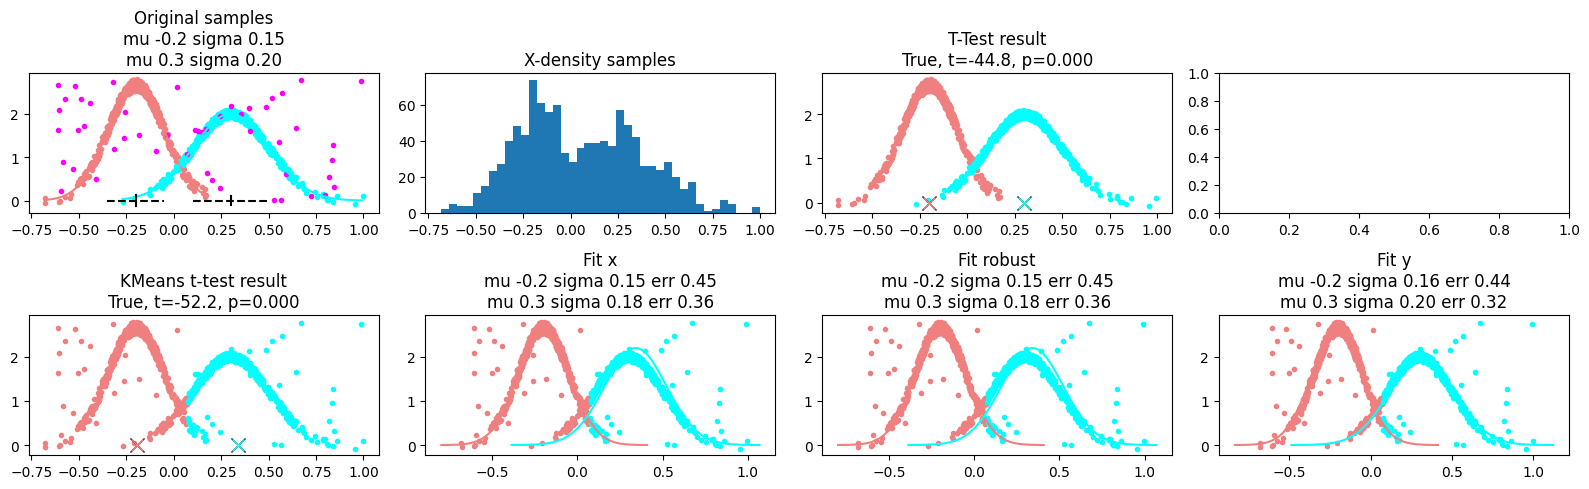

In [25]:
# Original
do_example(mus=(-0.2, 0.3), sigmas=(0.15, 0.2), noise_level=0.1, 
               n_samples=(500, 500, 50), n_clusters=2, perc_mean_err_clip=3.0)

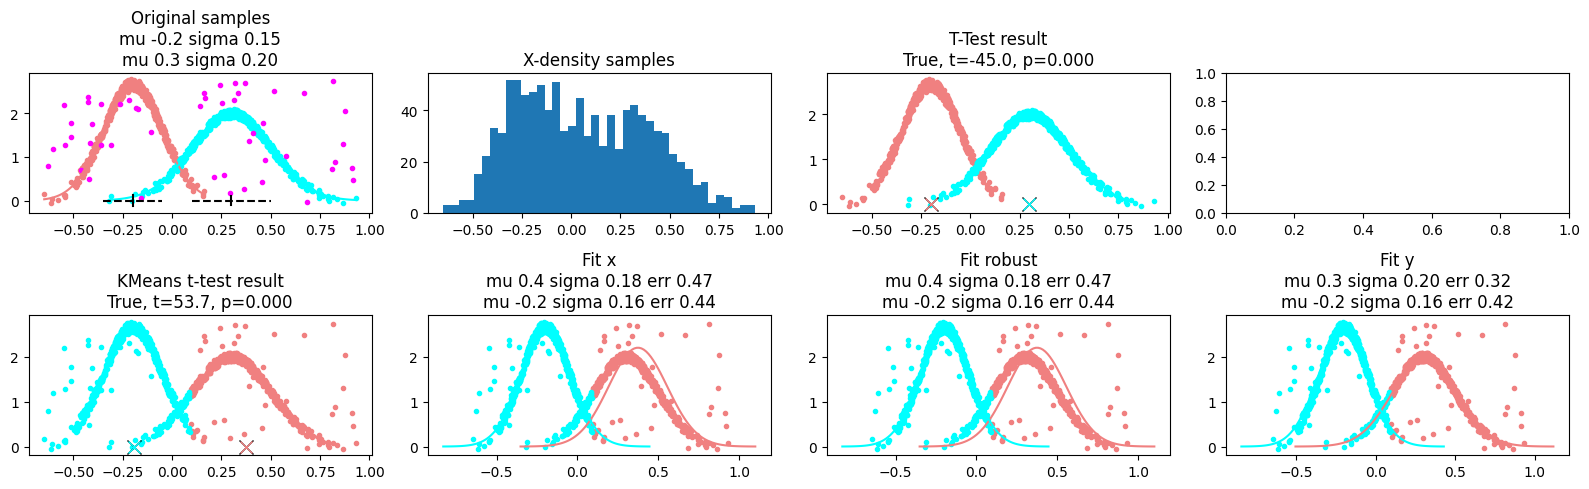

In [26]:
# Change so means are too close together

do_example(mus=(-0.2, 0.3), sigmas=(0.15, 0.2), noise_level=0.1, 
           n_samples=(500, 500, 50), n_clusters=2, perc_mean_err_clip=3.0)

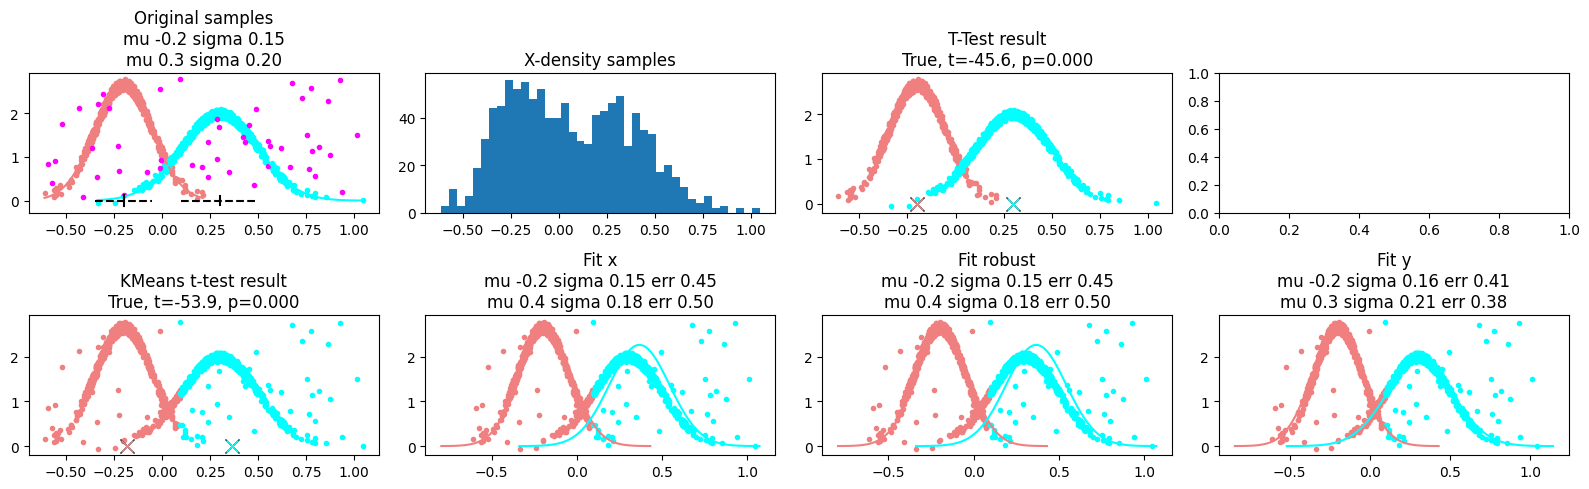

In [27]:
# Change so standard deviations overlap too much/are too broad

do_example(mus=(-0.2, 0.3), sigmas=(0.15, 0.2), noise_level=0.1, 
           n_samples=(500, 500, 50), n_clusters=2, perc_mean_err_clip=3.0)

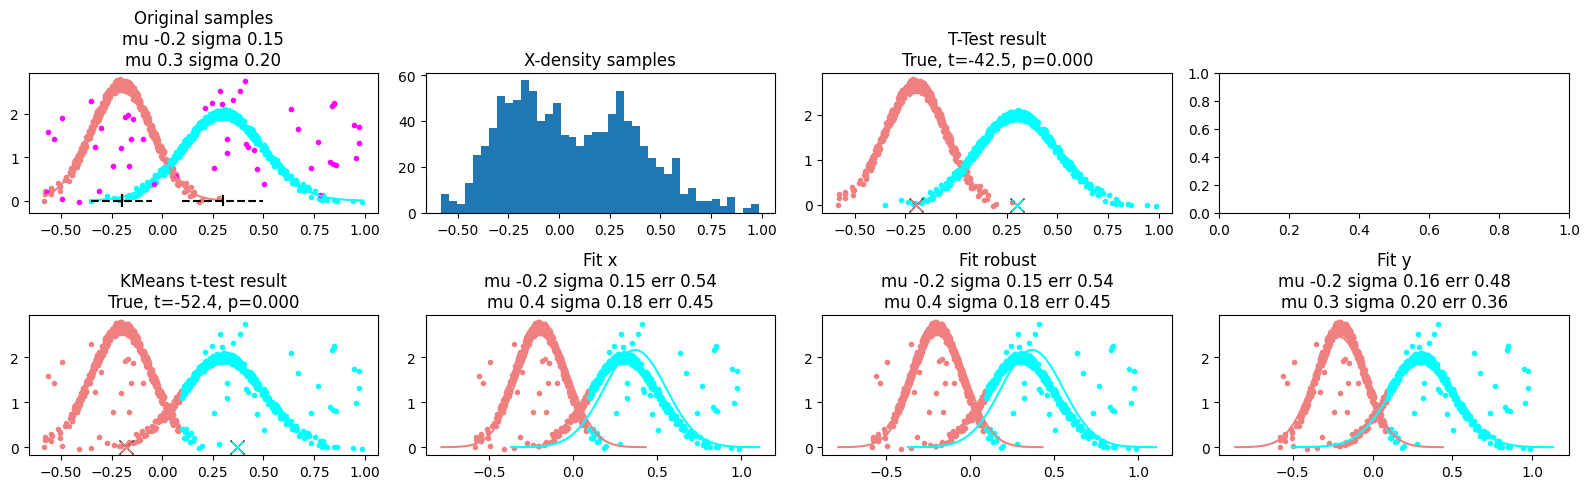

In [28]:
# Change ratio of samples of the two Gaussians

do_example(mus=(-0.2, 0.3), sigmas=(0.15, 0.2), noise_level=0.1, 
           n_samples=(500, 500, 50), n_clusters=2, perc_mean_err_clip=3.0)

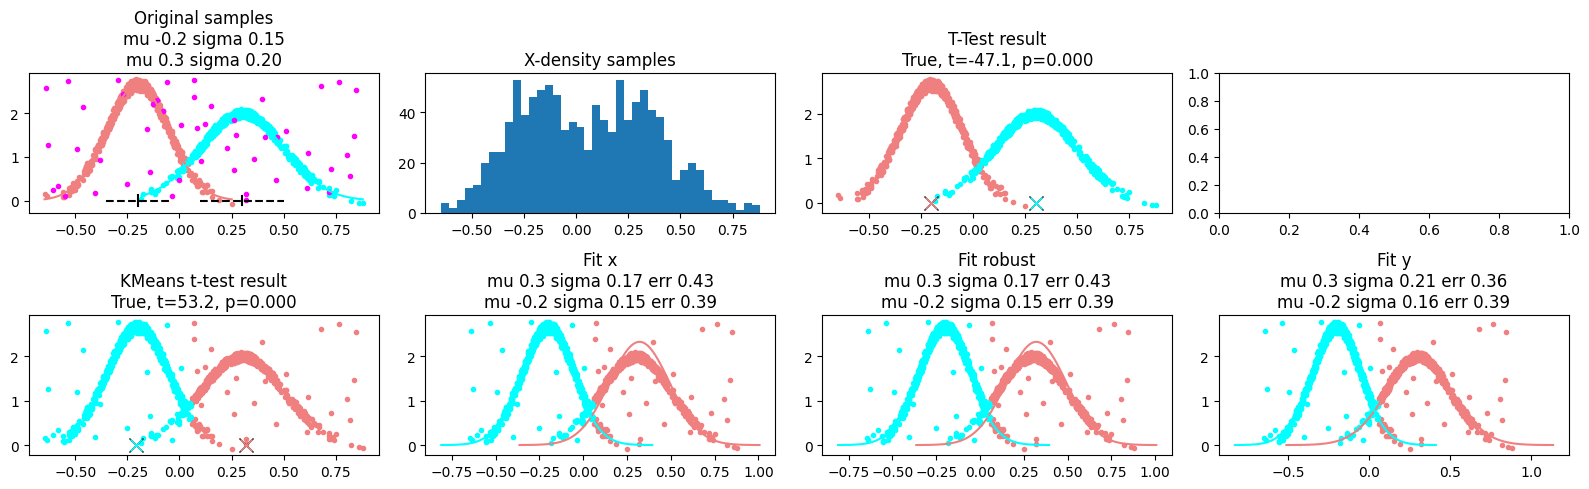

In [29]:
# Try 3 clusters (or 1)

do_example(mus=(-0.2, 0.3), sigmas=(0.15, 0.2), noise_level=0.1, 
           n_samples=(500, 500, 50), n_clusters=2, perc_mean_err_clip=3.0)

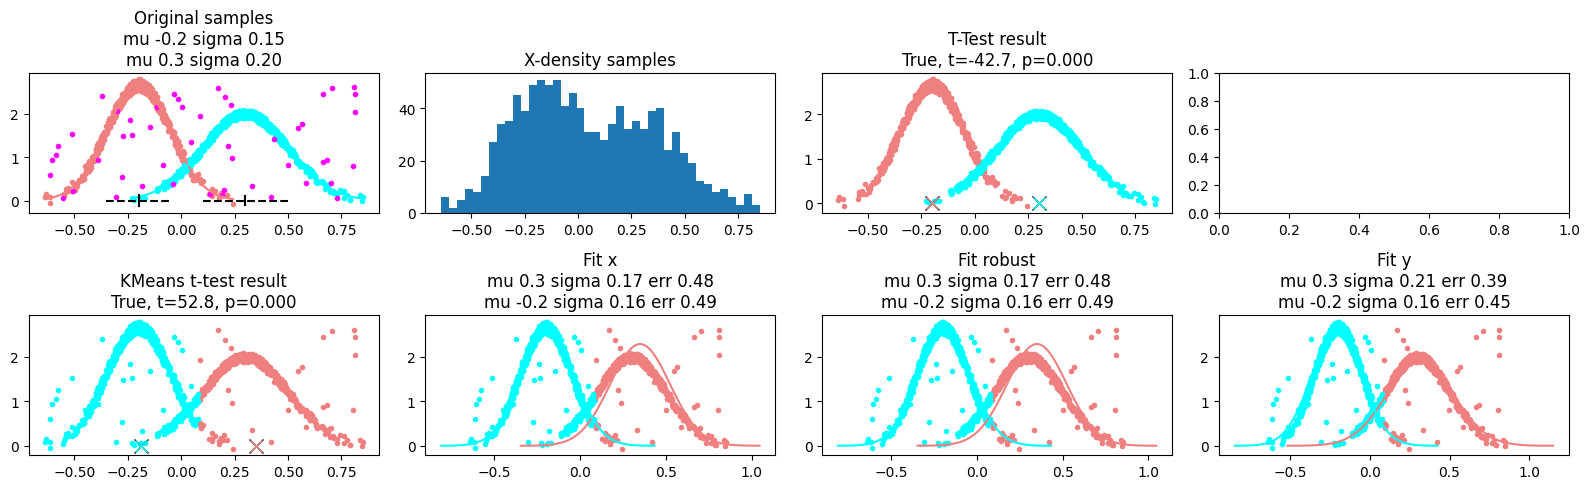

In [30]:
# Test better labeling/outlier removal

do_example(mus=(-0.2, 0.3), sigmas=(0.15, 0.2), noise_level=0.1, 
           n_samples=(500, 500, 50), n_clusters=2, perc_mean_err_clip=3.0)

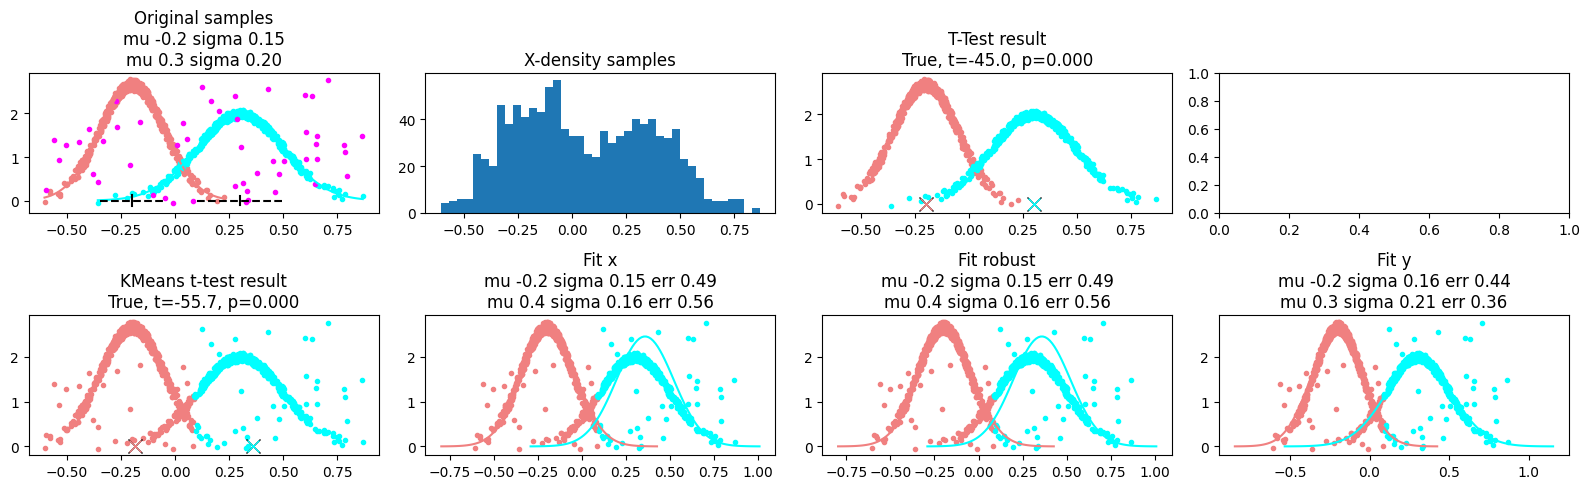

In [31]:
# Test outlier removal/fitting with a lot of noise

do_example(mus=(-0.2, 0.3), sigmas=(0.15, 0.2), noise_level=0.1, 
           n_samples=(500, 500, 50), n_clusters=2, perc_mean_err_clip=3.0)

<!-- END QUESTION -->

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [34]:

# List of names (creates a set)
worked_with_names = {"self"}
# List of URLS FW25(creates a set)
websites = {"coursera.org, brilliant.org, chatgpt for errors and concept questions"}
# Approximate number of hours, including lab/in-class time
hours = 10

In [35]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

- Do a restart then run all to make sure everything runs ok
- Save the file
- Submit this .ipynb file through gradescope
- Take out/suppress all extra print statements

Make sure your plots are visible - the last question is manually graded based on those plots

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

